In [1]:
import os
from glob import glob
from copy import deepcopy
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import signal

import obspy
from obspy.core import UTCDateTime
from obspy.signal.filter import envelope
from obspy.signal.invsim import paz_to_freq_resp

import changefinder

from configure import *

warnings.simplefilter('ignore')

In [2]:
# 可視化用関数
def vis(arr, color=None, figsize=(24, 4), ylim=(None, None)):
    plt.figure(figsize=figsize)
    plt.plot(arr, color=color)
    plt.ylim(ylim[0], ylim[1])
    plt.show()

# クラス・メソッドの定義

In [3]:
class MQ_Analysis:
    '''
    月震の解析用クラス
    
    Attributes:
        station (Int): ステーション番号
        lpx (Stream): LP-X DATA
        lpy (Stream): LP-Y DATA
        lpz (Stream): LP-Z DATA
        spz (Stream): SP-Z DATA
        lpx_du (Stream): LP-X DU DATA
        lpy_du (Stream): LP-Y DU DATA
        lpz_du (Stream): LP-Z DU DATA
        spz_du (Stream): SP-Z DU DATA
    '''
    def __init__(self, station):
        '''
        Initialization
        
        Args:
            input_station: ステーション番号
        '''
        self.station = station
        self.lpx = None
        self.lpy = None
        self.lpz = None
        self.spz = None
        self.lpx_du = None
        self.lpy_du = None
        self.lpz_du = None
        self.spz_du = None
        
        
    def download(self, url):
        '''
        データのダウンロード (obspyプラグインが必要)
        
        Args:
            url (Str): ダウンロードURL (例: http://darts.isas.jaxa.jp/pub/apollo/pse/p14s/pse.a14.1.71)
        '''
        # 末尾の数字に1を足す
        url2 = url.split('.')
        url2[-1] = str(int(url.split('.')[-1]) + 1)
        url2 = '.'.join(url2)

        # ダウンロード
        data = obspy.read(url)
        data += obspy.read(url2)
        
        # メンバ変数に格納 (selectが空集合の場合はNoneが入る)
        self.lpx = data.select(id='XA.S{}..LPX'.format(self.station))
        self.lpy = data.select(id='XA.S{}..LPY'.format(self.station))
        self.lpz = data.select(id='XA.S{}..LPZ'.format(self.station))
        self.spz = data.select(id='XA.S{}..SPZ'.format(self.station))
        
        # 複数データがあるものをmergeする
        if self.lpx != None: self.lpx.merge(method=1, fill_value='interpolate')
        if self.lpy != None: self.lpy.merge(method=1, fill_value='interpolate')
        if self.lpz != None: self.lpz.merge(method=1, fill_value='interpolate')
        if self.spz != None: self.spz.merge(method=1, fill_value='interpolate')

        # DU値を保存
        self.lpx_du = deepcopy(self.lpx)
        self.lpy_du = deepcopy(self.lpy)
        self.lpz_du = deepcopy(self.lpz)
        self.spz_du = deepcopy(self.spz)
        
        
    def read_sac(self, path, verbose=0):
        '''
        SACファイルを読み込む
        
        Args:
            path (Str): SACファイルが入ったディレクトリのパス
        '''
        files = glob(path + '/SMQ_*.sac')
        if verbose >= 1:
            print(files)
        
        # メンバ変数に格納
        file = path + '/SMQ_LPX.sac'
        if file in files: self.lpx = obspy.read(file)
        
        file = path + '/SMQ_LPY.sac'
        if file in files: self.lpy = obspy.read(file)
        
        file = path + '/SMQ_LPZ.sac'
        if file in files: self.lpz = obspy.read(file)
        
        file = path + '/SMQ_SPZ.sac'
        if file in files: self.spz = obspy.read(file)

        # DU値を保存
        self.lpx_du = deepcopy(self.lpx)
        self.lpy_du = deepcopy(self.lpy)
        self.lpz_du = deepcopy(self.lpz)
        self.spz_du = deepcopy(self.spz)

    
    
    def to_sac(self, path):
        '''
        SACファイルに出力
        
        Args:
            path (Str): SACファイルの出力先のパス
        '''
        # ステーション番号のディレクトリを作成
        dir_path = path + '/S' + str(self.station)
        os.mkdir(dir_path)
        
        # SACファイルの出力
        if self.lpx != None:
            self.lpx.write(dir_path + '/SMQ_LPX.sac', format='SAC')
        if self.lpy != None:
            self.lpy.write(dir_path + '/SMQ_LPY.sac', format='SAC')
        if self.lpz != None:
            self.lpz.write(dir_path + '/SMQ_LPZ.sac', format='SAC')
        if self.spz != None:
            self.spz.write(dir_path + '/SMQ_SPZ.sac', format='SAC')
        
    
    def remove_noise(
        self,
        channel,
        span = 1000,
        threshold = 3.0,
        times = 5,
        verbose = 0
    ):
        '''
        ノイズを除去する
        
        Args:
            channel (Str): ノイズ除去を行うデータのチャンネル -> {'ALL', 'LPX', 'LPY', 'LPZ', 'SPZ'}
            span (Int): ウィンドウサイズ
            threshold (Float): 閾値
            times (Int): ノイズ除去処理のループ回数
            verbose (Int): 0:何も表示しない, 1:ノイズ除去前後のグラフ比較
        '''
        if channel == 'ALL':
            # ALLオプションで全チャンネルに対して前処理を行う
            channels = ['LPX', 'LPY', 'LPZ', 'SPZ']
        else:
            channels = [channel]
            
        for ch in channels:
            # メンバ変数をコピー
            if ch == 'LPX': data = self.lpx
            elif ch == 'LPY': data = self.lpy
            elif ch == 'LPZ': data = self.lpz
            elif ch == 'SPZ': data = self.spz
            else: assert False

            if data is None: continue
                
            if verbose >= 1:
                starttime = data[0].stats.starttime
                endtime = data[0].stats.endtime
                
            # 型変換 (Ndarray -> Series)
            data = pd.Series(data[0].data)
                
            if verbose >= 1:
                # ノイズ除去前のグラフを描画
                plt.figure(figsize=(24, 4))
                plt.title('{} ({} - {})'.format(ch, starttime, endtime))
                plt.plot(data.index, data, label='pre', color='blue')
                
                # 1周目のみノイズを描画するためのフラグ
                flag_visualizing = True
                
            # ノイズの除去
            for _ in [0]*times: # times回ループ
                ewm_mean = data.ewm(span=span).mean()  # 指数加重移動平均
                ewm_std = data.ewm(span=span).std()  # 指数加重移動標準偏差
                noise = data[(data - ewm_mean).abs() > ewm_std * threshold]
                
                if verbose >= 1 and flag_visualizing:
                    # 閾値やノイズの描画 (1周目のみ描画)
                    plt.fill_between(
                        data.index,
                        ewm_mean - ewm_std * threshold,
                        ewm_mean + ewm_std * threshold,
                        alpha=0.2,
                        color='cyan'
                    )
                    plt.scatter(noise.index, noise, label='noise', color='red')
                    flag_visualizing = False
                
                data[noise.index] = ewm_mean[noise.index]
                
            # 型変換 (Ndarray -> Series)
            data = np.array(data)
            
            if verbose >= 1:
                # ノイズ除去後のグラフを描画
                plt.plot(data, label='post', color='lime')
                plt.legend()
                plt.show()
                
        # メンバ変数にノイズ除去後のデータを戻す
        if ch == 'LPX': self.lpx[0].data = data
        elif ch == 'LPY': self.lpy[0].data = data
        elif ch == 'LPZ': self.lpz[0].data = data
        elif ch == 'SPZ': self.spz[0].data = data
        
        
    def preprocessing(self, channel):
        '''
        前処理

        Args:
            channel (Str): 前処理を行うデータのチャンネル -> {'ALL', 'LPX', 'LPY', 'LPZ', 'SPZ'}
        '''
        if channel == 'ALL':
            # ALLオプションで全チャンネルに対して前処理を行う
            channels = ['LPX', 'LPY', 'LPZ', 'SPZ']
        else:
            channels = [channel]
            
        for ch in channels:
            # メンバ変数をコピー
            if ch == 'LPX': data = self.lpx
            elif ch == 'LPY': data = self.lpy
            elif ch == 'LPZ': data = self.lpz
            elif ch == 'SPZ': data = self.spz
            else: assert False

            if data is None: continue
            
            # 前処理
            if ch != 'SPZ':
                data.detrend(type='linear') # detrend
                data.detrend('demean') # demean
                data.taper(0.05, type='cosine')
                data.filter('lowpass', freq=pre_high_freq, zerophase=True)
                data.filter('highpass', freq=pre_low_freq, zerophase=True)
                data.simulate(paz_remove=paz_AP) # Remove response
                data.taper(0.05, type='cosine')
                data.differentiate(method='gradient')
                
                data.filter('lowpass', freq=post_high_freq, zerophase=True)
                data.filter('highpass', freq=post_low_freq, zerophase=True)

            elif ch == 'SPZ':
                data.detrend(type='linear') # detrend
                data.detrend('demean') # demean
                data.taper(0.05, type='cosine')
                data.filter('lowpass', freq=pre_high_freq_sp, zerophase=True)
                data.filter('highpass', freq=pre_low_freq_sp, zerophase=True)
                data.simulate(paz_remove=paz_SP) # Remove response
                data.taper(0.05, type='cosine')
                data.differentiate(method='gradient')
                
                data.filter('lowpass', freq=post_high_freq_sp, zerophase=True)
                data.filter('highpass', freq=post_low_freq_sp, zerophase=True)
            
            # メンバ変数に前処理後のデータを戻す
            if ch == 'LPX': self.lpx = data
            elif ch == 'LPY': self.lpy = data
            elif ch == 'LPZ': self.lpz = data
            elif ch == 'SPZ': self.spz = data


    def rm_outlier(
        self,
        channel,
        times = 5,
        verbose = 0
    ):
        '''
        ノイズを除去する
        
        Args:
            channel (Str): ノイズ除去を行うデータのチャンネル -> {'ALL', 'LPX', 'LPY', 'LPZ', 'SPZ'}
            verbose (Int): 0:何も表示しない, 1:ノイズ除去前後のグラフ比較
        '''
        if channel == 'ALL':
            # ALLオプションで全チャンネルに対して前処理を行う
            channels = ['LPX', 'LPY', 'LPZ', 'SPZ']
        else:
            channels = [channel]
            
        for ch in channels:
            # メンバ変数をコピー
            if ch == 'LPX': data = self.lpx
            elif ch == 'LPY': data = self.lpy
            elif ch == 'LPZ': data = self.lpz
            elif ch == 'SPZ': data = self.spz
            else: assert False
            
            if data is None: continue

            if verbose >= 1:
                fig = plt.figure(figsize=(24, 8))
                ax = fig.add_subplot(2, 1, 1)
                ax.plot(data[0].data)

            window = 3000
            env_th, std_th = 3, 1.5
            for _ in range(times):
                b = np.ones(window)/window
                env = abs(signal.hilbert(data[0].data))
                env_mv = np.convolve(env, b, mode='same') ## Moving Average

                # Removing
                data[0].data[
                    np.abs(data[0].data) > (env_mv * env_th + np.std(data[0].data) * std_th)
                ] = 0

            if verbose >= 1:
                ax.plot(env_mv * env_th + np.std(data[0].data) * std_th)
                ax = fig.add_subplot(2, 1, 2)
                ax.plot(data[0].data)
                plt.show()
                
        # メンバ変数にノイズ除去後のデータを戻す
        if ch == 'LPX': self.lpx = data
        elif ch == 'LPY': self.lpy = data
        elif ch == 'LPZ': self.lpz = data
        elif ch == 'SPZ': self.spz = data


    def rm_absolute_outlier(
        self,
        channel,
        verbose = 0
    ):
        '''
        DU値の極端なノイズを除去する
        
        Args:
            channel (Str): ノイズ除去を行うデータのチャンネル -> {'ALL', 'LPX', 'LPY', 'LPZ', 'SPZ'}
            verbose (Int): 0:何も表示しない, 1:ノイズ除去前後のグラフ比較
        '''
        if channel == 'ALL':
            # ALLオプションで全チャンネルに対して前処理を行う
            channels = ['LPX', 'LPY', 'LPZ', 'SPZ']
        else:
            channels = [channel]
            
        for ch in channels:
            # メンバ変数をコピー
            if ch == 'LPX': data = self.lpx
            elif ch == 'LPY': data = self.lpy
            elif ch == 'LPZ': data = self.lpz
            elif ch == 'SPZ': data = self.spz
            else: assert False
            
            if data is None: continue

            if verbose >= 1:
                fig = plt.figure(figsize=(24, 8))
                ax = fig.add_subplot(2, 1, 1)
                ax.plot(data[0].data)

            # 極端なノイズを除去
            data_tmp = pd.Series(deepcopy(data[0].data))
            EPSILON = 1e-3
            data_tmp[data_tmp < EPSILON] = None
            upper_th = data_tmp.std()*30 + data_tmp.median()
            lower_th = -data_tmp.std()*30 + data_tmp.median()
            data_tmp[data_tmp > upper_th] = None
            data_tmp[data_tmp < lower_th] = None
            data_tmp = data_tmp.fillna(data_tmp.median())
            data[0].data = np.array(data_tmp)

            if verbose >= 1:
                ax.plot(np.repeat(upper_th, len(data[0].data)), color='red')
                ax.plot(np.repeat(lower_th, len(data[0].data)), color='red')
                ax = fig.add_subplot(2, 1, 2)
                ax.plot(data[0].data)
                plt.show()
                
        # メンバ変数にノイズ除去後のデータを戻す
        if ch == 'LPX': self.lpx = data
        elif ch == 'LPY': self.lpy = data
        elif ch == 'LPZ': self.lpz = data
        elif ch == 'SPZ': self.spz = data
            

    def plot_spectrogram(self, channel):
        '''
        Plot Spectrogram

        Args:
            channel (Str): 前処理を行うデータのチャンネル -> {'ALL', 'LPX', 'LPY', 'LPZ', 'SPZ'}
        '''
        if channel == 'ALL':
            # ALLオプションで全チャンネルに対して前処理を行う
            channels = ['LPX', 'LPY', 'LPZ', 'SPZ']
        else:
            channels = [channel]
            
        for ch in channels:
            # メンバ変数をコピー
            if ch == 'LPX': data, data_du = self.lpx, self.lpx_du
            elif ch == 'LPY': data, data_du = self.lpy, self.lpy_du
            elif ch == 'LPZ': data, data_du = self.lpz, self.lpz_du
            elif ch == 'SPZ': data, data_du = self.spz, self.spz_du
            else: assert False

            if data is None: continue

            # Init figure
            fig = plt.figure(figsize=(24, 8))
            plt.title(f'{ch}', fontsize='xx-large', pad=30)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['bottom'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)
            plt.axis('off')

            # Plot Waveform (DU)
            ax = fig.add_subplot(2, 2, 1)
            ax.plot(data_du[0].data)
            plt.title('Waveform (DU)')

            # Plot Waveform
            ax = fig.add_subplot(2, 2, 3)
            ax.plot(data[0].data)
            plt.title('Waveform (Preprocessed)')

            # Plot Spectrogram (Low Freq)
            ax = fig.add_subplot(2, 2, 4)
            f, t, sxx = signal.spectrogram(
                data[0].data * 1e9,
                nfft=int(f_lp * times),
                nperseg=int(f_lp * times),
                fs=int(f_lp),
                noverlap=int(f_lp * times / 2),
                scaling='density',
                mode='psd',
                window=('hamming')
            )
            plt.pcolormesh(t, f, np.sqrt(sxx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
            ax.set_ylabel("Frequency (Hz)", fontsize=font)
            # ax.set_xlabel(xlabel, fontsize=font+2)
            ax.set_xlim(0, 7200)
            ax.set_xticks([0,1800, 3600, 5400, 7200])
            ax.set_ylim(0.1, 3)
            ax.set_yticks([0.1,0.5, 1.0, 2.0])
            plt.tick_params(labelsize=font+2)
            ax.set_yscale("log")
            plt.colorbar(orientation ='vertical', label='PSD ($nm/s/√Hz$)')
            plt.grid(which='major')
            plt.title('Spectrogram (Low Freq)')

            # Plot Spectrogram (High Freq)
            ax = fig.add_subplot(2, 2, 2)
            f, t, sxx = signal.spectrogram(
                data[0].data * 1e9,
                nfft=int(f_sp * times),
                nperseg=int(f_sp * times),
                fs=int(f_sp),
                noverlap=int(f_sp * times / 2),
                scaling='density',
                mode='psd',
                window=('hamming')
            )
            plt.pcolormesh(t, f, np.sqrt(sxx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
            ax.set_ylabel("Frequency (Hz)", fontsize=font)
            # ax.set_xlabel(xlabel, fontsize=font+2)
            ax.set_xlim(0, 7200)
            ax.set_xticks([0,1800, 3600, 5400, 7200])
            ax.set_ylim(1, 26)
            ax.set_yticks([0.1,0.5, 1.0, 5.0, 10, 20])
            plt.tick_params(labelsize=font+2)
            ax.set_yscale("log")
            plt.colorbar(orientation ='vertical', label='PSD ($nm/s/√Hz$)')
            plt.grid(which='major')
            plt.title('Spectrogram (High Freq)')

            plt.show()

# スペクトログラム (ノイズ除去前)

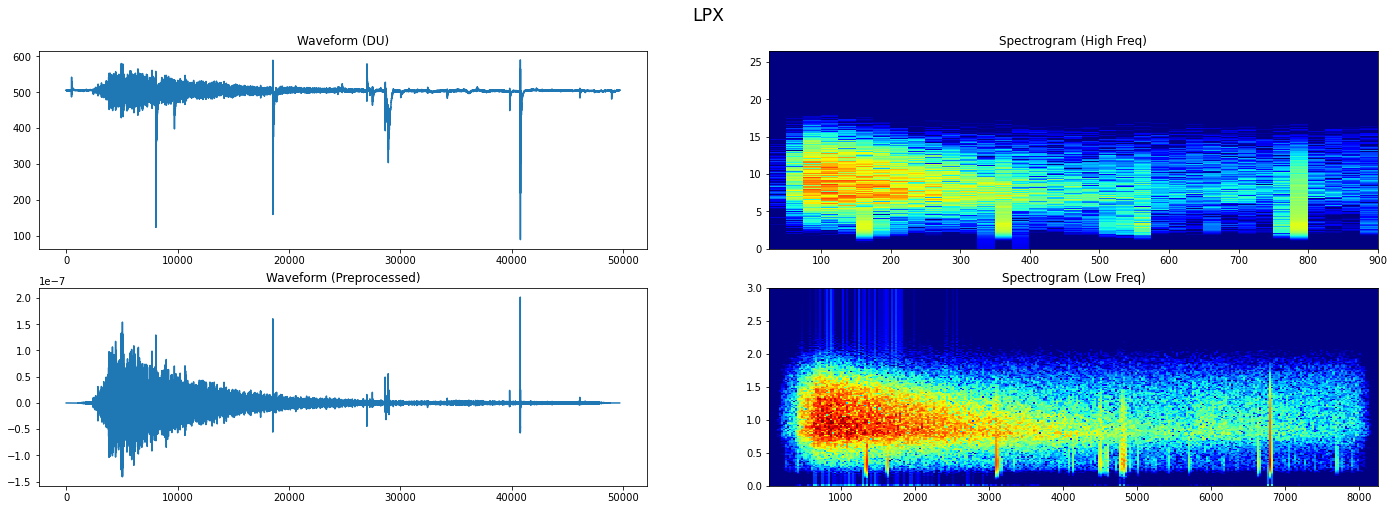

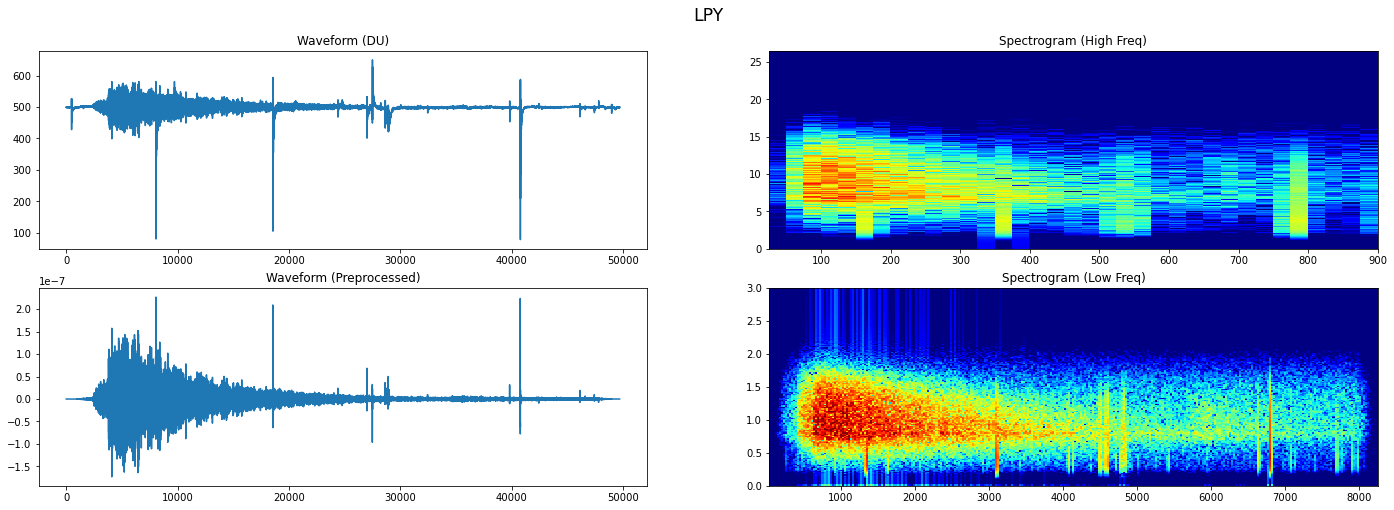

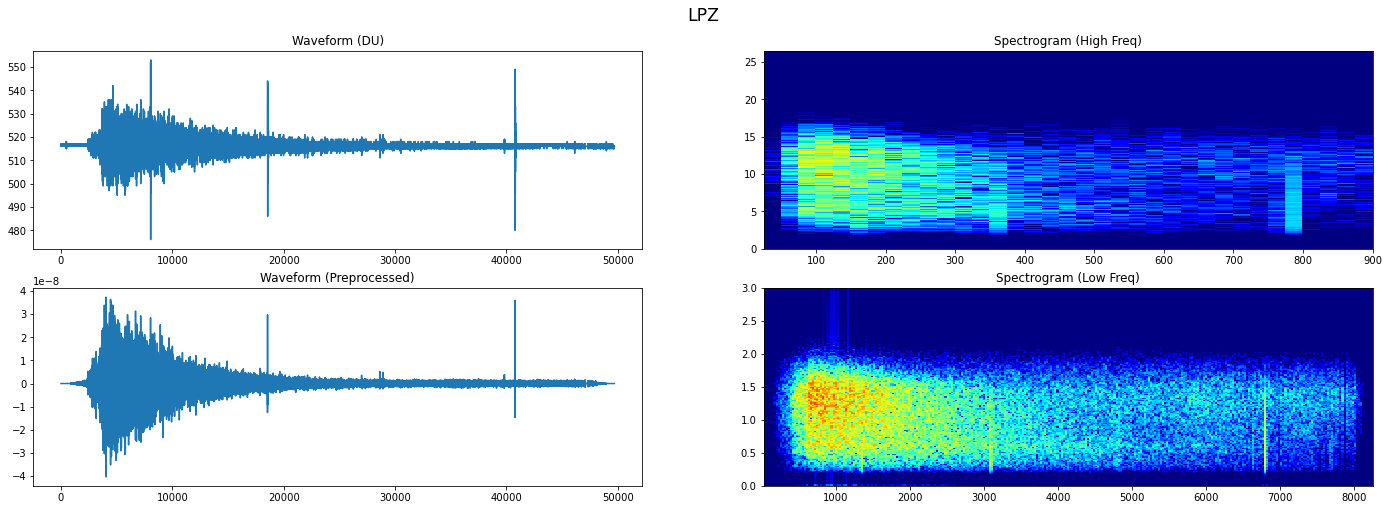

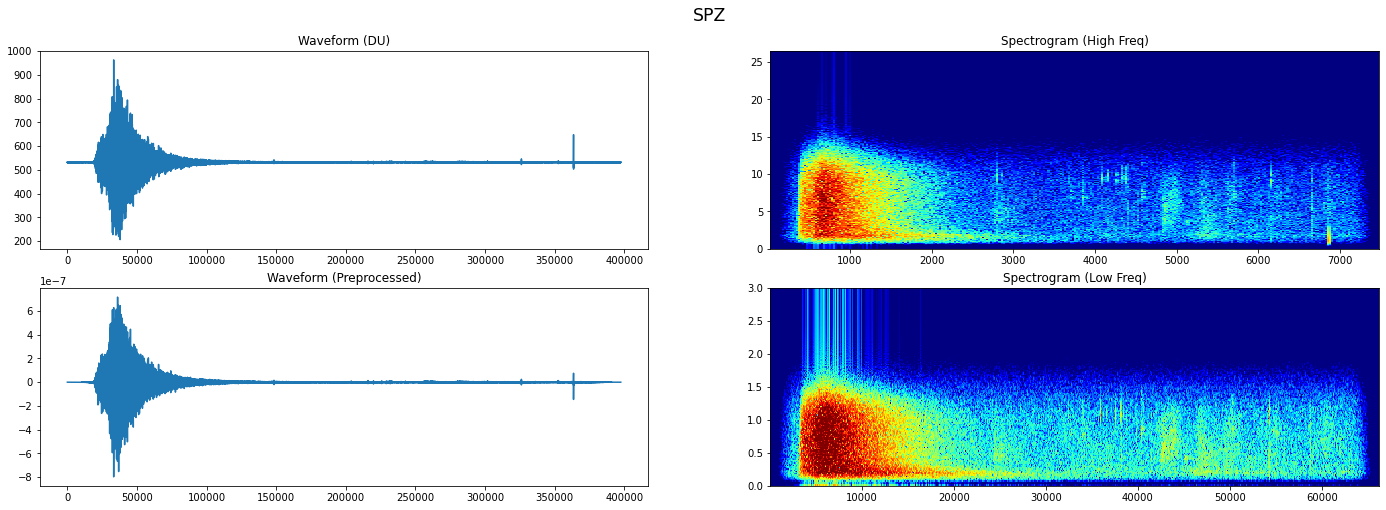

In [22]:
smq = MQ_Analysis(14)
smq.read_sac('./dataset/SMQ_710417/S14')

smq.preprocessing('ALL')

smq.plot_spectrogram('ALL')

# スペクトログラム (ノイズ除去後)

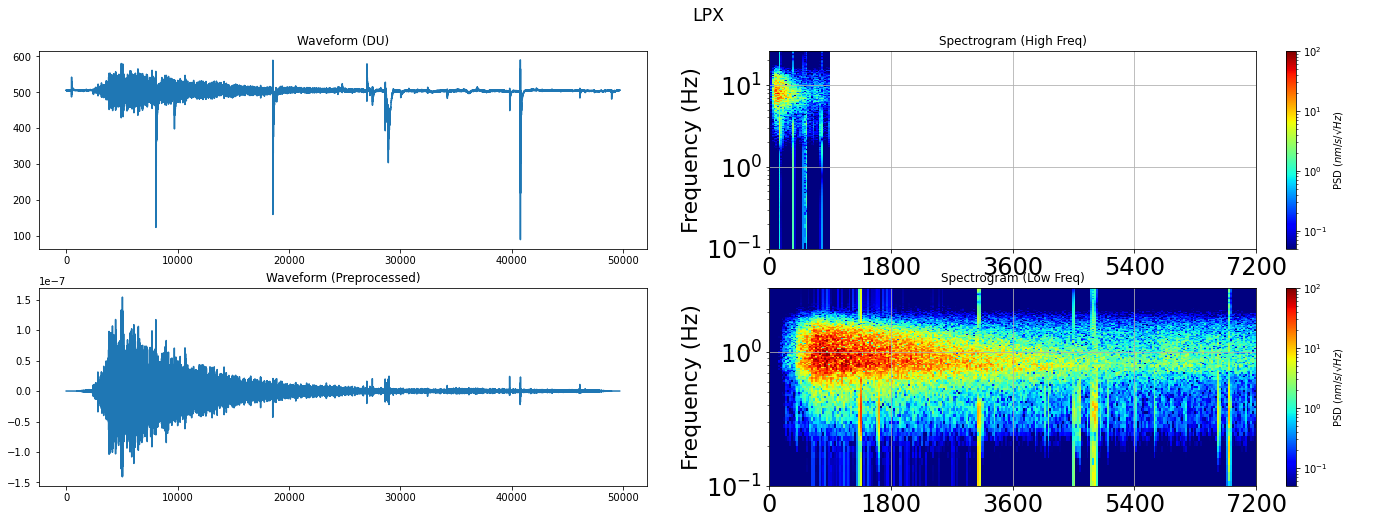

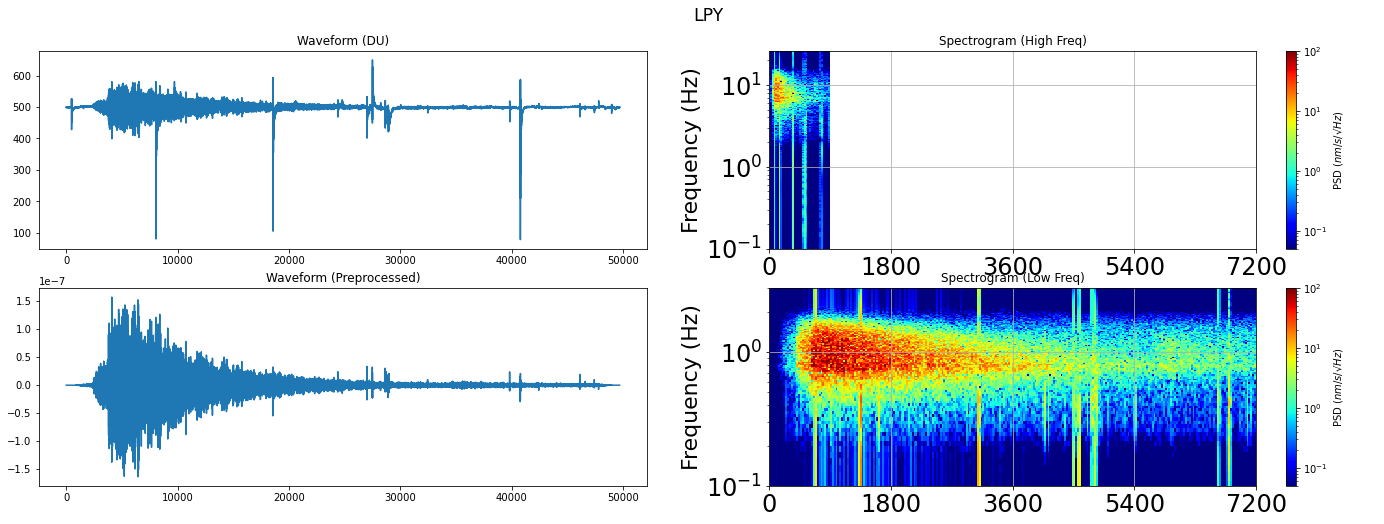

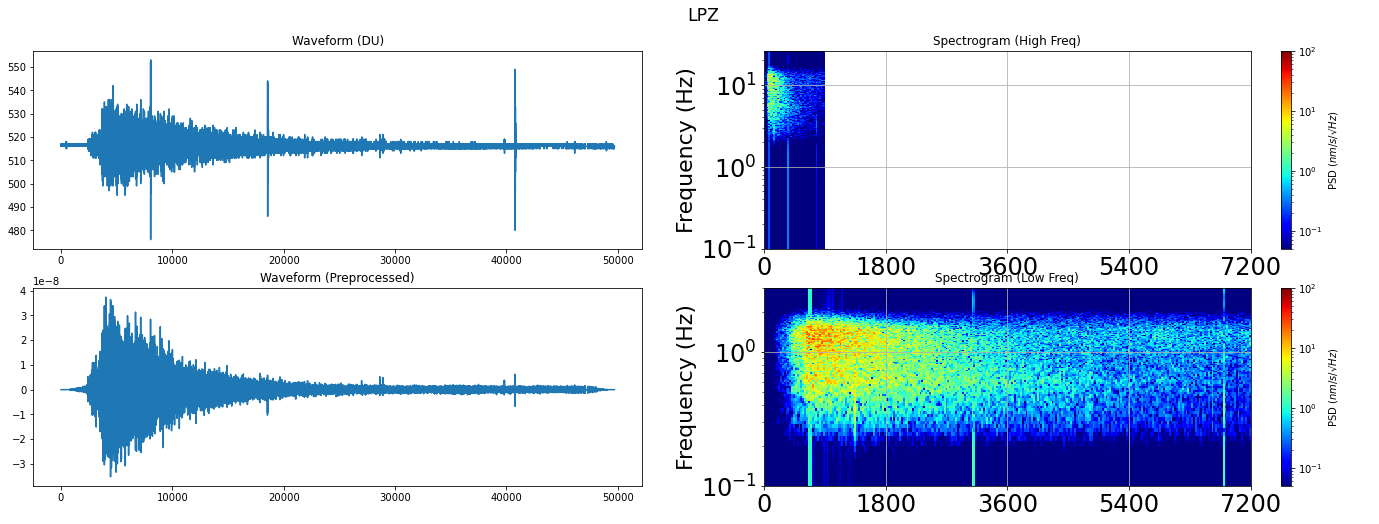

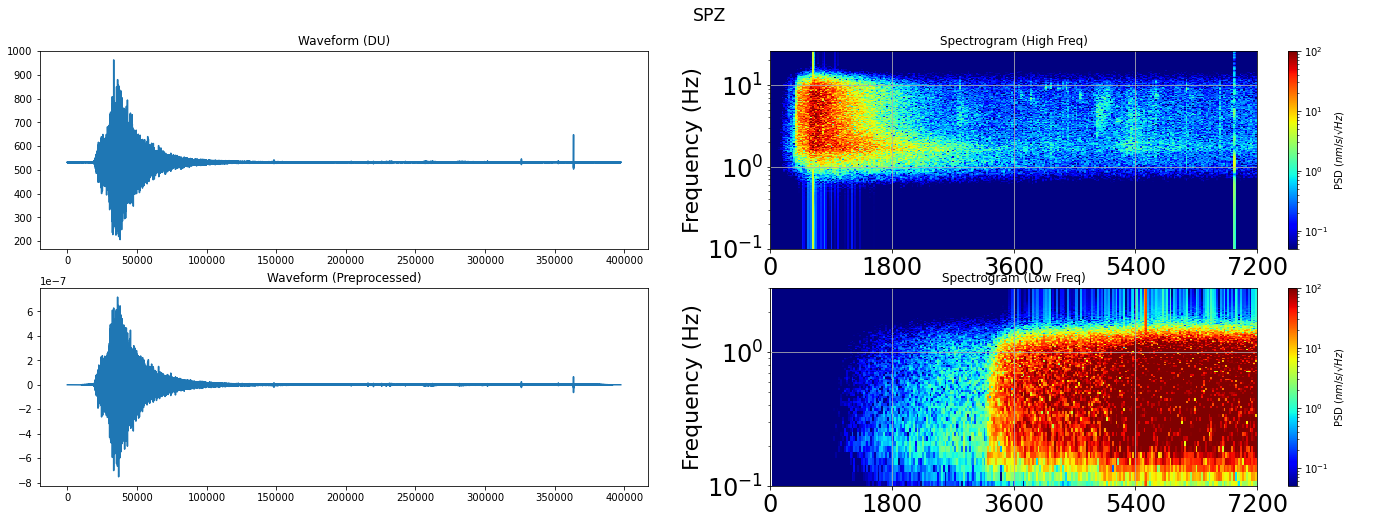

In [82]:
smq = MQ_Analysis(14)
smq.read_sac('./dataset/SMQ_710417/S14')

smq.preprocessing('ALL')
smq.rm_outlier('ALL')

smq.plot_spectrogram('ALL')

# changefinderを用いた変化点検出

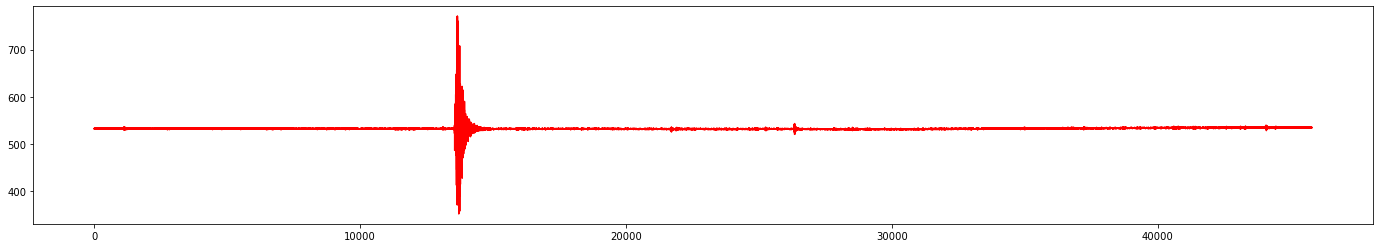

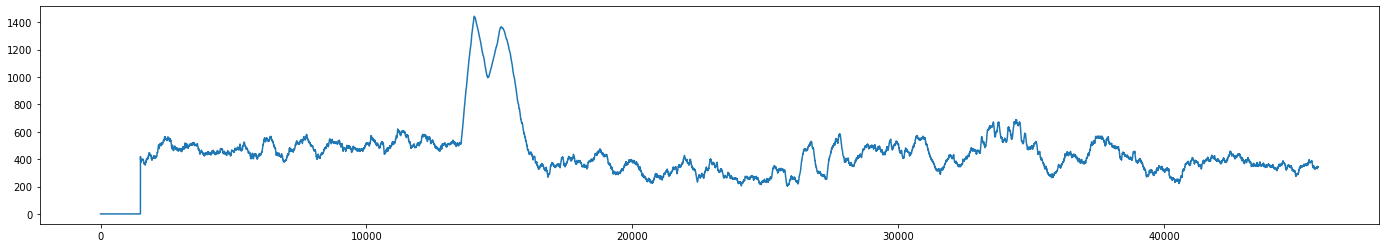

In [50]:
cf = changefinder.ChangeFinder(r=0.5, order=1, smooth=1000)

ret = []
for i in smq.spz[0].data[::100]:
    score = cf.update(i)
    ret.append(score)

# 可視化
vis(smq.spz[0].data[::100],'r')
vis(ret)

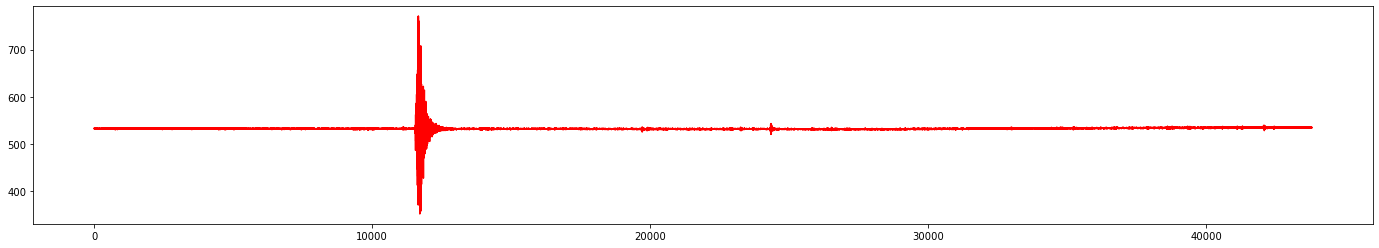

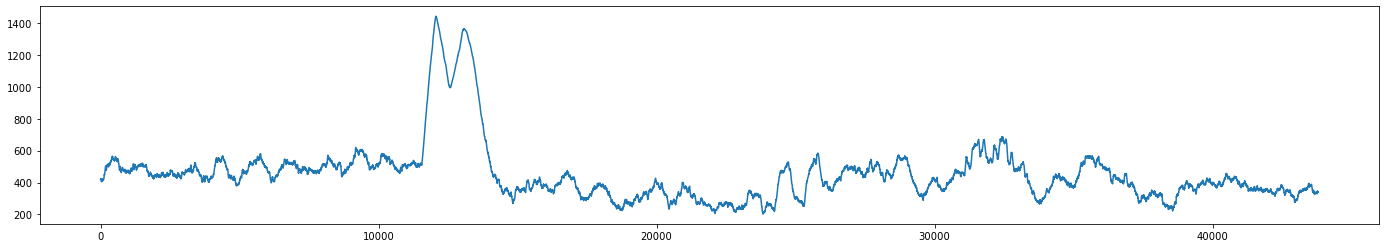

In [51]:
vis(smq.spz[0].data[::100][2000:],'r')
vis(ret[2000:])

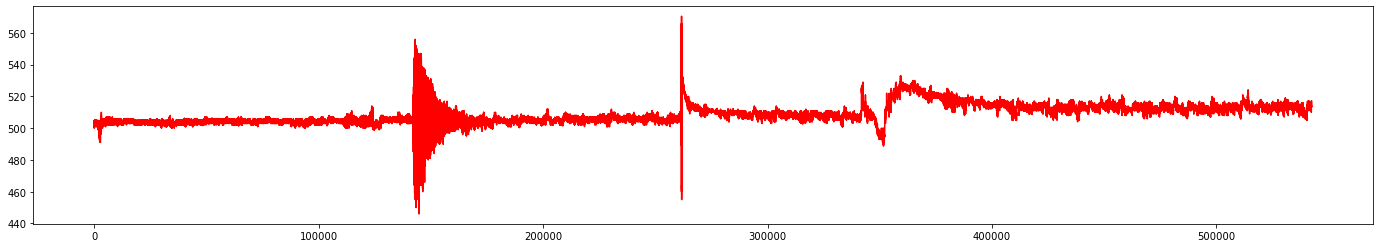

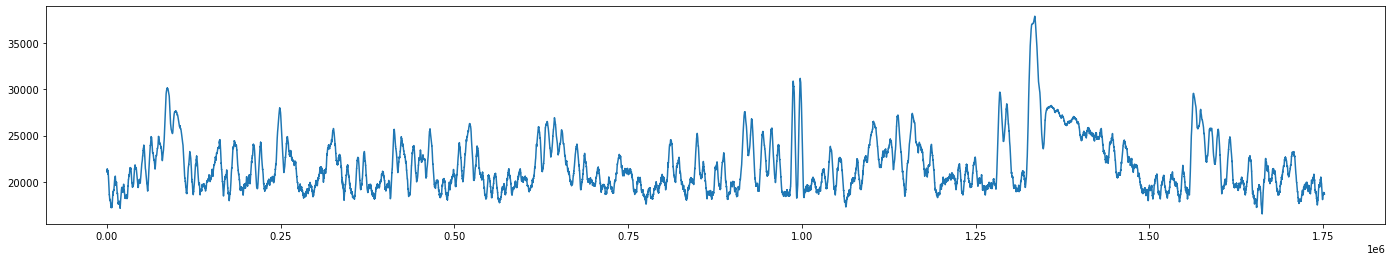

In [36]:
# 可視化
vis(smq.spz[0].data[:],'r')
vis(ret[30000:])

# TEST

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓   rm_absolute_outlier()   ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


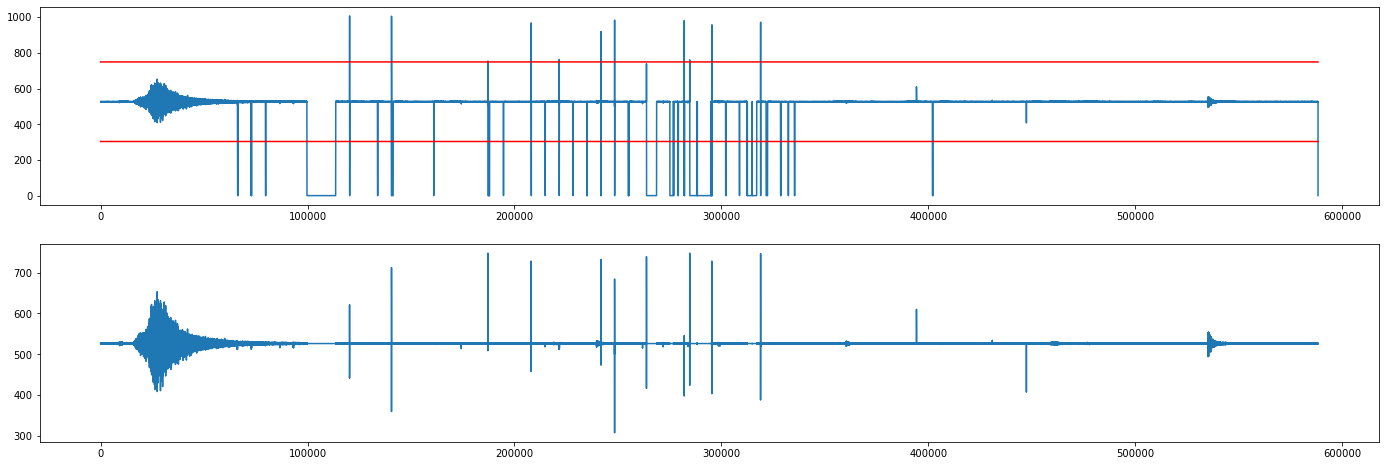

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓   rm_outlier()   ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


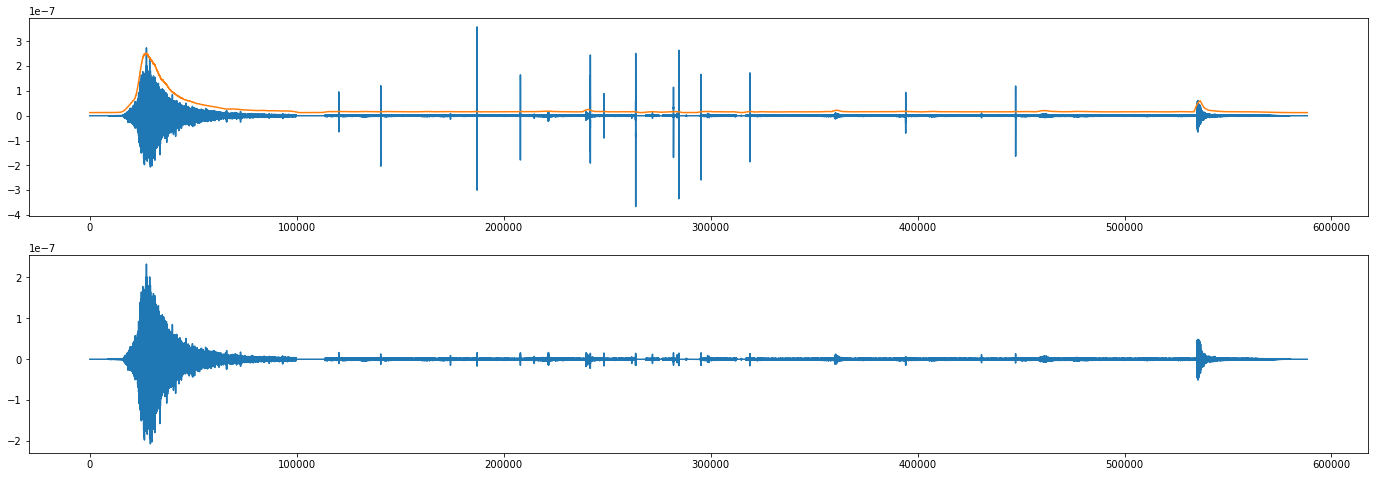

In [31]:
station_num = 14
# station_num = 16
# path = './dataset/SMQ_710417/S14'
path = './dataset/SMQ_710520/S14'
# path = './dataset/SMQ_710711/S14'
# path = './dataset/SMQ_720102/S14'
# path = './dataset/SMQ_730208/S14'
# path = './dataset/SMQ_740223/S16'

smq = MQ_Analysis(station_num)
smq.read_sac(path)
ch = 'SPZ'
print('↓' * 30 + '   rm_absolute_outlier()   ' + '↓' * 30)
smq.rm_absolute_outlier(ch, verbose=1)
smq.preprocessing('ALL')
print('↓' * 30 + '   rm_outlier()   ' + '↓' * 30)
smq.rm_outlier(ch, times=5, verbose=1)

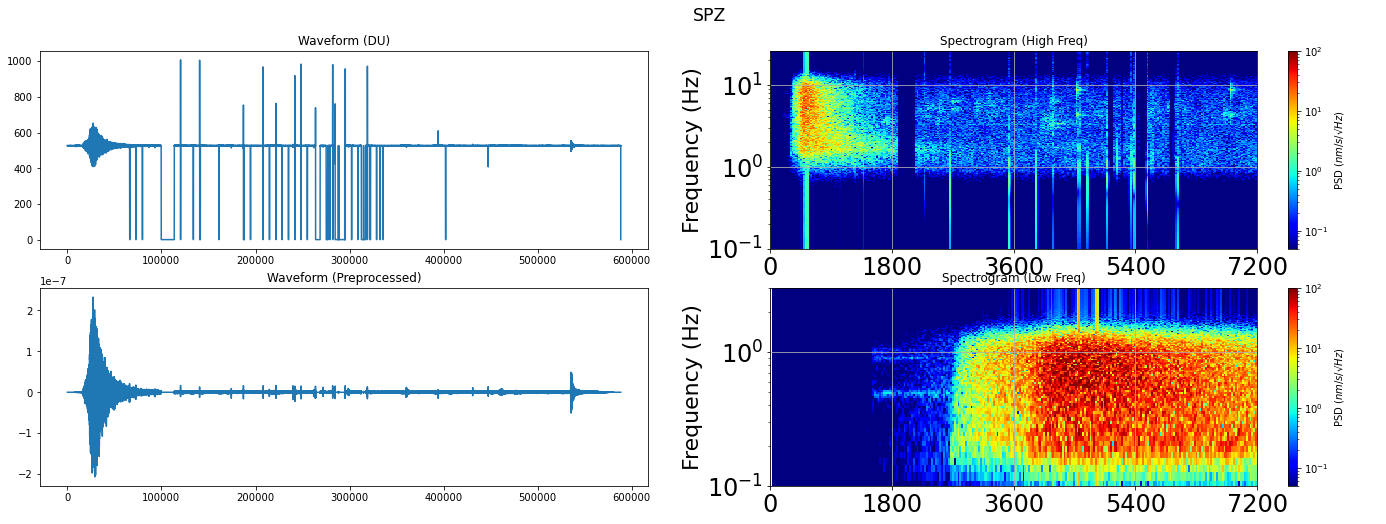

In [32]:
smq.plot_spectrogram('SPZ')

<AxesSubplot:>

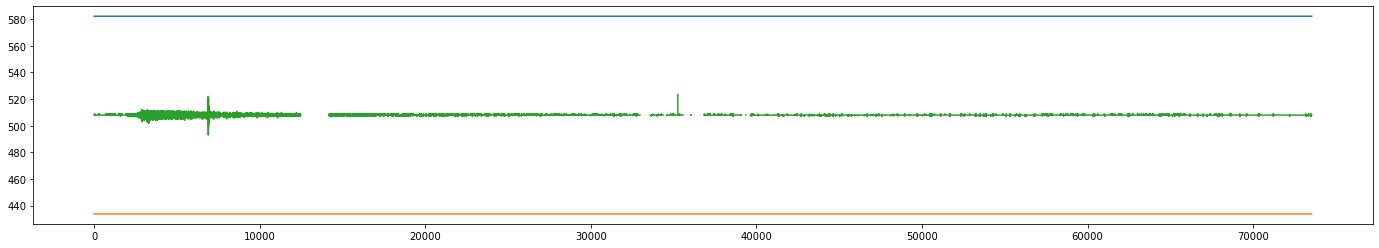

In [64]:
d = pd.Series(deepcopy(d_orig))
EPSILON = 1e-3
d[d < EPSILON] = None
upper_th = d.std()*10 + d.median()
lower_th = -d.std()*10 + d.median()
d[d > upper_th] = None
d[d < lower_th] = None

# Plot
plt.figure(figsize=(24, 4))
plt.plot(np.repeat(upper_th, len(d)))
plt.plot(np.repeat(lower_th, len(d)))
d.plot()

In [33]:
print(1e-3)

0.001
